<a href="https://colab.research.google.com/github/TioSatrio100/LSTM-ADHD/blob/main/LSTM_ADHD3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.decomposition import FastICA

# **Data Preparation & EDA**

In [19]:
# Load data
dt = pd.read_csv("adhd2.csv")

In [20]:
dt.head()

,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T7,T8,P7,P8,Fz,Cz,Pz,class
0,85.0,261.0,52.0,226.0,52.0,200.0,126.0,310.0,-20.0,236.0,126.0,200.0,-20.0,200.0,-20.0,347.0,85.0,50.0,85.0,0
1,156.0,508.0,126.0,226.0,126.0,236.0,89.0,310.0,-57.0,273.0,273.0,420.0,16.0,310.0,-57.0,89.0,297.0,121.0,85.0,0
2,297.0,473.0,89.0,332.0,52.0,163.0,-167.0,236.0,-20.0,126.0,236.0,273.0,-57.0,126.0,-167.0,273.0,402.0,15.0,-160.0,0
3,191.0,402.0,89.0,156.0,89.0,89.0,-94.0,163.0,-167.0,200.0,89.0,200.0,-57.0,52.0,-167.0,89.0,85.0,156.0,-90.0,0
4,156.0,402.0,89.0,121.0,52.0,126.0,-131.0,89.0,16.0,89.0,126.0,200.0,-20.0,52.0,-131.0,52.0,332.0,121.0,-55.0,0


In [21]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918628 entries, 0 to 1918627
Data columns (total 20 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Fp1     float64
 1   Fp2     float64
 2   F3      float64
 3   F4      float64
 4   C3      float64
 5   C4      float64
 6   P3      float64
 7   P4      float64
 8   O1      float64
 9   O2      float64
 10  F7      float64
 11  F8      float64
 12  T7      float64
 13  T8      float64
 14  P7      float64
 15  P8      float64
 16  Fz      float64
 17  Cz      float64
 18  Pz      float64
 19  class   int64  
dtypes: float64(19), int64(1)
memory usage: 292.8 MB


In [22]:
top_2000 = dt.head(2000)


In [23]:
bottom_2000 = dt.tail(2000)


In [24]:
df = pd.concat([top_2000, bottom_2000], ignore_index=True)
df

,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T7,T8,P7,P8,Fz,Cz,Pz,class
0,85.0,261.0,52.0,226.0,52.0,200.0,126.0,310.0,-20.0,236.0,126.0,200.0,-20.0,200.0,-20.0,347.0,85.0,50.0,85.0,0
1,156.0,508.0,126.0,226.0,126.0,236.0,89.0,310.0,-57.0,273.0,273.0,420.0,16.0,310.0,-57.0,89.0,297.0,121.0,85.0,0
2,297.0,473.0,89.0,332.0,52.0,163.0,-167.0,236.0,-20.0,126.0,236.0,273.0,-57.0,126.0,-167.0,273.0,402.0,15.0,-160.0,0
3,191.0,402.0,89.0,156.0,89.0,89.0,-94.0,163.0,-167.0,200.0,89.0,200.0,-57.0,52.0,-167.0,89.0,85.0,156.0,-90.0,0
4,156.0,402.0,89.0,121.0,52.0,126.0,-131.0,89.0,16.0,89.0,126.0,200.0,-20.0,52.0,-131.0,52.0,332.0,121.0,-55.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,50.0,85.0,52.0,50.0,52.0,52.0,52.0,16.0,16.0,52.0,126.0,126.0,126.0,126.0,163.0,89.0,50.0,-19.0,50.0,1
3996,121.0,85.0,126.0,15.0,126.0,16.0,52.0,16.0,-20.0,16.0,163.0,89.0,163.0,16.0,126.0,-20.0,50.0,-55.0,50.0,1
3997,15.0,-55.0,52.0,-90.0,89.0,-57.0,89.0,-20.0,200.0,16.0,89.0,16.0,126.0,-20.0,52.0,-20.0,-19.0,-19.0,85.0,1
3998,85.0,121.0,126.0,50.0,200.0,52.0,163.0,52.0,163.0,163.0,163.0,89.0,200.0,126.0,163.0,163.0,85.0,121.0,121.0,1


In [25]:
# Checking for missing values
for col in df.columns:
    if(df[col].isnull().sum()>0):
        print(col)

Classes are almost balanced. We can get away with the difference.
class
0    2000
1    2000
Name: count, dtype: int64


<Axes: title={'center': 'Label'}, xlabel='class'>

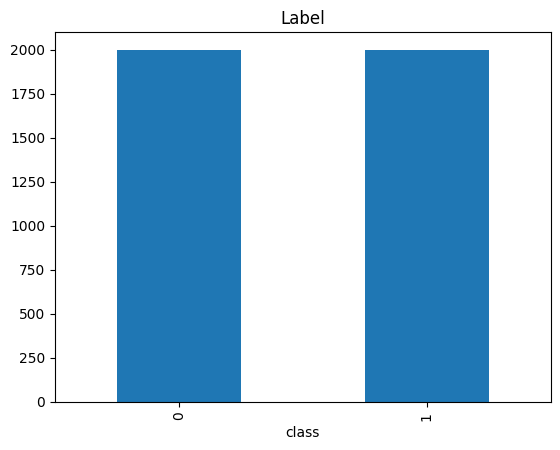

In [26]:
print(f"Classes are almost balanced. We can get away with the difference.\n{df['class'].value_counts()}")
df['class'].value_counts().plot(kind='bar', color='tab:blue', title='Label')

# **Data Signal Visualization**

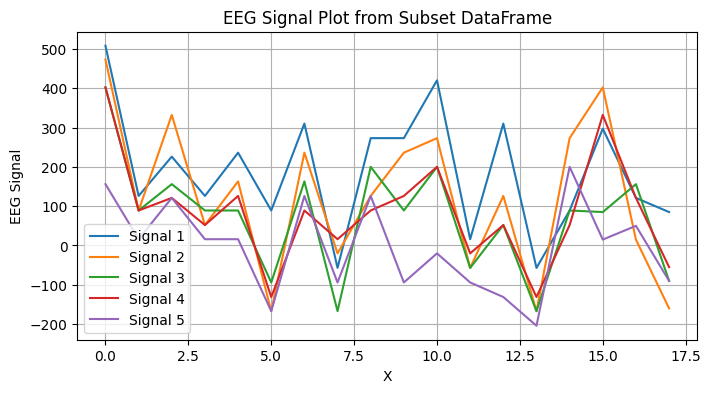

In [27]:
# Memilih 5 sampel sinyal EEG untuk plot dari subset DataFrame
sample_signal_1 = df.iloc[1, 1:-1].values
sample_signal_2 = df.iloc[2, 1:-1].values
sample_signal_3 = df.iloc[3, 1:-1].values
sample_signal_4 = df.iloc[4, 1:-1].values
sample_signal_5 = df.iloc[5, 1:-1].values

# Menghasilkan sumbu waktu berdasarkan jumlah data poin
time_axis = np.arange(0, len(sample_signal_1), 1)

# Menghitung waktu berdasarkan durasi tiap data poin
sampling_rate = 1  # Ubah dengan frekuensi sampling yang sesuai
time = time_axis / sampling_rate

# Membuat plot sinyal EEG dari subset DataFrame
plt.figure(figsize=(8, 4))
plt.plot(time, sample_signal_1, label='Signal 1')
plt.plot(time, sample_signal_2, label='Signal 2')
plt.plot(time, sample_signal_3, label='Signal 3')
plt.plot(time, sample_signal_4, label='Signal 4')
plt.plot(time, sample_signal_5, label='Signal 5')
plt.xlabel('X')
plt.ylabel('EEG Signal')
plt.title('EEG Signal Plot from Subset DataFrame')
plt.legend()
plt.grid(True)
plt.show()



# **Data Pre-processing**

In [28]:
# Pre-processing
def butterworth_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Filter sinyal dengan bandpass filter
fs = 200
lowcut = 1
highcut = 50

numeric_columns = df.select_dtypes(include=[np.number]).columns
data_filtered = df[numeric_columns].copy()
for column in numeric_columns:
    data_filtered[column] = butterworth_filter(df[column].values, lowcut, highcut, fs)

In [29]:
# Drop non-numeric columns
data_numeric = df.select_dtypes(include=[np.number])

# Memisahkan fitur (X) dan label (y)
Y = df['class'].copy()
X = df.drop('class', axis=1).copy()

# Apply Single-Channel ICA
ica = FastICA(n_components=15, whiten='arbitrary-variance')
ica_components = ica.fit_transform(data_filtered)

# **Data Modelling**

In [30]:
# Normalisasi data menggunakan StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [31]:
X_train, x_test, Y_train, y_test = train_test_split(X, Y,random_state=111, test_size=0.3)
X_train, x_val, Y_train, y_val=train_test_split(X_train, Y_train, random_state=111, test_size=0.3)

In [32]:

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),  # Dropout dengan tingkat dropout 0.5 (50%)
    Dense(256, activation='relu'),
    Dropout(0.3),  # Dropout dengan tingkat dropout 0.3 (30%)
    Dense(1, activation='sigmoid')  # untuk klasifikasi biner
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
history = model.fit(X_train, Y_train,
                         batch_size=64,
                         epochs=10,
                         validation_split=0.2)

Epoch 1/10
25/25 [==============================] - 2s 17ms/step - loss: 0.5790 - accuracy: 0.6601 - val_loss: 0.4637 - val_accuracy: 0.8163
Epoch 2/10
25/25 [==============================] - 0s 7ms/step - loss: 0.4619 - accuracy: 0.8017 - val_loss: 0.3676 - val_accuracy: 0.8622
Epoch 3/10
25/25 [==============================] - 0s 7ms/step - loss: 0.3821 - accuracy: 0.8444 - val_loss: 0.2897 - val_accuracy: 0.9107
Epoch 4/10
25/25 [==============================] - 0s 8ms/step - loss: 0.3109 - accuracy: 0.8744 - val_loss: 0.2221 - val_accuracy: 0.9286
Epoch 5/10
25/25 [==============================] - 0s 9ms/step - loss: 0.2624 - accuracy: 0.8960 - val_loss: 0.1715 - val_accuracy: 0.9592
Epoch 6/10
25/25 [==============================] - 0s 12ms/step - loss: 0.2135 - accuracy: 0.9126 - val_loss: 0.1416 - val_accuracy: 0.9643
Epoch 7/10
25/25 [==============================] - 0s 11ms/step - loss: 0.1835 - accuracy: 0.9349 - val_loss: 0.1129 - val_accuracy: 0.9694
Epoch 8/10
25/25 

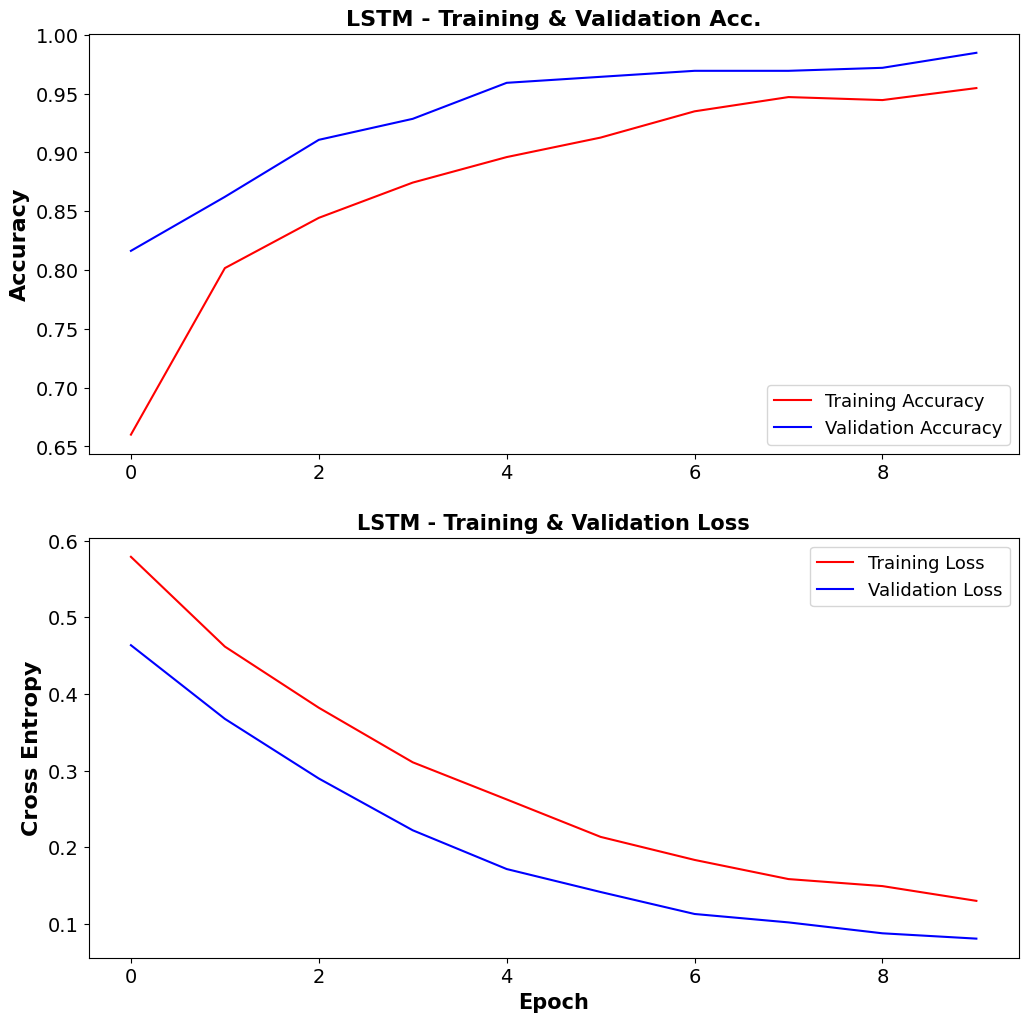

In [34]:
acc =history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss =history.history['val_loss']


plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Acc.', fontsize=16, weight='bold')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()

In [35]:
# Evaluasi model pada data test
_, test_accuracy = model.evaluate(x_test, y_test)

# Menghitung akurasi dalam persen
test_accuracy_percent = test_accuracy * 100

print(f'Accuracy on test data: {test_accuracy_percent:.2f}%')

38/38 [==============================] - 0s 2ms/step - loss: 0.1138 - accuracy: 0.9658
Accuracy on test data: 96.58%
